# pytket-dqc Example Usage

In this notebook we gather some example uses of the pytket-dqc package.

## Networks

Near term networks of quantum servers are specified by two properties. The fist is the server coupling, detailing which servers are connected to which others. This is specified by a list of pairs of integers, where each pair signifies that there is a connection between those two servers. The second is the qubits each server contains. This is specified by a dictionary from the server to a list of qubits it contains. 

An example is given below, where blue lines indicate connections between servers, and red lines indicate connections between qubits within servers. The vertex labels are the indexes of the qubits.

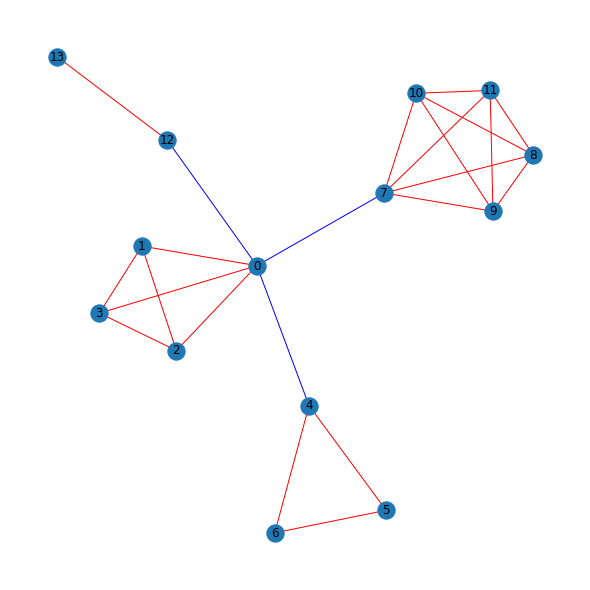

In [1]:
from pytket_dqc.networks import NISQNetwork

network = NISQNetwork([[0,1], [0,2], [0,3]], {0:[0,1,2,3], 1:[4,5,6], 2:[7,8,9,10,11], 3:[12,13]})
network.draw_nisq_network()

## Circuits

The `HypergraphCircuits` class adds some additional properties and methods to the standard `Circuit` pytket class. These predominantly relate to a hypergraph representation of the circuit. `HypergraphCircuits` are initialised from a standard tket `Circuit` object, as seen in the following example. Additional functionality is provided to visualise the corresponding hypergraph. For details on the correspondence between circuits and hypergraphs please see the paper [Automated distribution of quantum circuits via hypergraph partitioning](https://arxiv.org/abs/1811.10972).

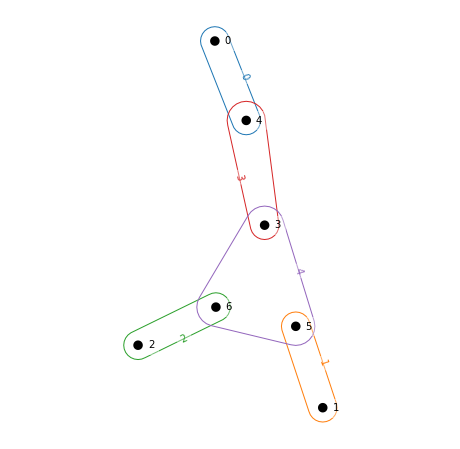

In [2]:
from pytket_dqc.circuits import HypergraphCircuit
from pytket.circuit.display import render_circuit_jupyter
from pytket import Circuit

circ = Circuit(4).CZ(0,3).Rz(0.5,3).CZ(1,3).CZ(2,3).Rz(0.5,3)

dist_circ = HypergraphCircuit(circ)
render_circuit_jupyter(dist_circ.circuit)
dist_circ.draw()

Note that the accepted gate set for pytket-dqc is at present Rx, CZ, and Rz. However pytket-dqc includes some utilities for rebasing your circuit if it is not in the correct gate set initially.

In [3]:
from pytket_dqc.utils import dqc_rebase

circ = Circuit(3).CY(0,1).CZ(1,2).H(1).CX(1,0)
render_circuit_jupyter(circ)

dqc_rebase.apply(circ)
render_circuit_jupyter(circ)

## Allocators

pytket-dqc provides several allocators, which are themselves a selection of methods to assign qubits and gates to servers. Allocators return a `Distribution` which describes the placement of qubits and gates onto servers, and packets of gates which can be implemented in using one e-bit. Each allocator takes a different approach to minimising the e-bit cost of the resulting implementation. All of the allocators currently offered by pytket-dqc are guaranteed to return a valid distribution.

Here we will work though some example use of these allocators. To do so let's define a simple network.

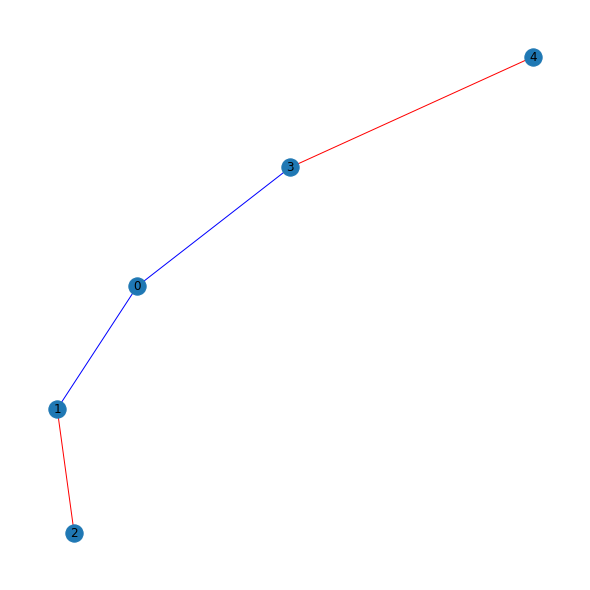

In [4]:
network = NISQNetwork([[0,1], [0,2]], {0:[0], 1:[1,2], 2:[3,4]})
network.draw_nisq_network()

Let's also define a circuit to allocate. Some classes of circuits are predefined within pytket-dqc. Cyclic circuits, where CZ gates act in a circle, are one such class of circuits. These circuits are defined by the number of qubits they act on and the number of layers of cycles.

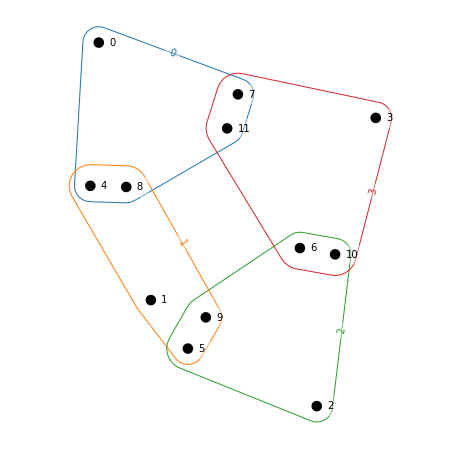

In [5]:
from pytket_dqc.circuits import CyclicHypergraphCircuit

dist_circ = CyclicHypergraphCircuit(4,2)
render_circuit_jupyter(dist_circ.circuit)
dist_circ.draw()

One such alocator is `Brute`, which performs a brutefoce search of all placements of qubits and gates onto servers, returning the one with the lowest cost. It is the slowest method, but returns the best result every time.

In [6]:
from pytket_dqc.allocators import Brute
import time

brute_alloc = Brute()

start = time.time()
distribution = brute_alloc.allocate(dist_circ, network)
print("time to distribute", time.time() - start)
print("final placement", distribution.placement)
print("final placement cost", distribution.placement.cost(dist_circ, network))

time to distribute 284.13171219825745
final placement {0: 0, 4: 0, 7: 0, 8: 0, 11: 0, 1: 1, 5: 0, 9: 0, 2: 1, 6: 0, 10: 0, 3: 2}
final placement cost 3


`Annealing` is another approach, which uses simulated annealing as a means to arrive at a valid distribution.

In [7]:
from pytket_dqc.allocators import Annealing

annealing_alloc = Annealing()

start = time.time()
distribution = annealing_alloc.allocate(dist_circ, network)
print("time to distribute", time.time() - start)
print("final placement", distribution.placement)
print("final placement cost", distribution.placement.cost(dist_circ, network))

time to distribute 0.12248492240905762
final placement {0: 2, 4: 0, 7: 1, 8: 0, 11: 1, 1: 0, 5: 1, 9: 1, 2: 1, 6: 1, 10: 1, 3: 1}
final placement cost 3


HypergraphPartitioning uses the [Karlsruhe Hypergraph Partitioning Framework](https://kahypar.org/) to derive a distribution.

In [8]:
from pytket_dqc.allocators import HypergraphPartitioning

hypergraph_alloc = HypergraphPartitioning()

start = time.time()
distribution = hypergraph_alloc.allocate(dist_circ, network)
print("time to distribute", time.time() - start)
print("final placement", distribution.placement)
print("final placement cost", distribution.placement.cost(dist_circ, network))
assert distribution.placement.is_valid(dist_circ, network)

time to distribute 0.013248920440673828
final placement {0: 1, 1: 2, 2: 0, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 0, 10: 1, 11: 1}
final placement cost 3


`Routing` makes use of routing and placement and routing techniques available in TKET. Here the network architecture as a whole is interpreted as a backend architecture, with noise on edges between servers set to be very high. Routing is guaranteed to generate a valid placement, and often very quickly. Unfortunately, it does not do a great job of distinguishing between connections within servers and connections between them. This can result in a high e-bit cost. `Routing` will also alter the circuit

In [9]:
from pytket_dqc.allocators import Routing

routing_alloc = Routing()

start = time.time()
distribution = routing_alloc.allocate(dist_circ, network)
print("time to distribute", time.time() - start)
print("final placement", distribution.placement)
print("final placement cost", distribution.placement.cost(dist_circ, network))

time to distribute 0.0164639949798584
final placement {0: 0, 5: 1, 6: 0, 8: 2, 10: 0, 12: 2, 13: 0, 15: 2, 17: 0, 19: 2, 21: 1, 22: 0, 24: 2, 26: 0, 28: 2, 29: 0, 1: 1, 4: 1, 7: 1, 9: 1, 11: 1, 14: 1, 16: 1, 18: 1, 20: 1, 23: 1, 25: 1, 27: 1, 2: 1, 3: 2}
final placement cost 15


## Larger Example

Let's see how far we can push these schemes. Let's create a larger network:

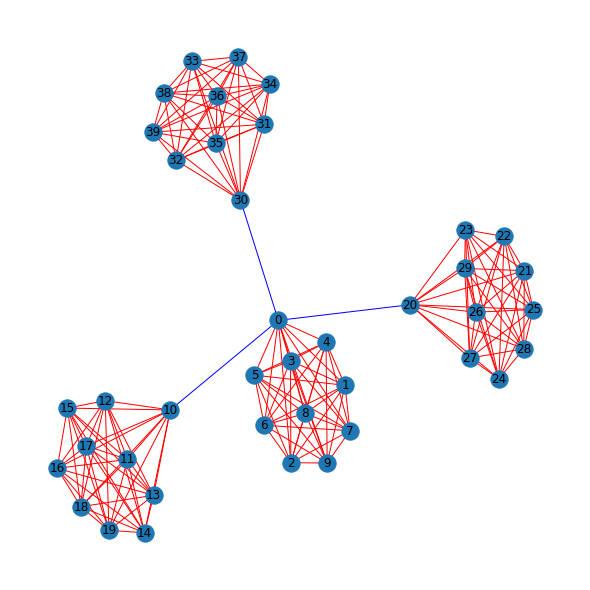

In [10]:
network = NISQNetwork([[0,1], [0,2], [0,3]], {0:[i for i in range(10)], 1:[i for i in range(10, 20)], 2:[i for i in range(20,30)], 3:[i for i in range(30,40)]})
network.draw_nisq_network()

and a larger circuit:

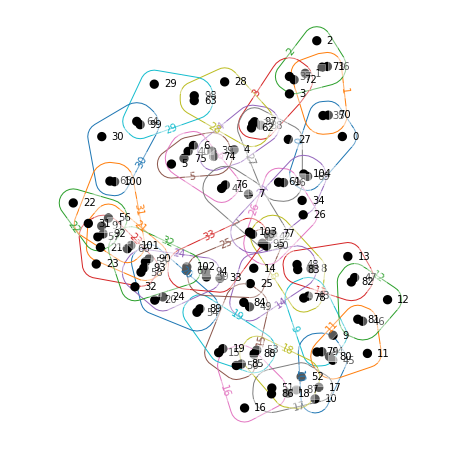

In [11]:
dist_circ = CyclicHypergraphCircuit(35,2)
render_circuit_jupyter(dist_circ.circuit)
dist_circ.draw()

We have already seen that `Brute` can be quite slow, so let's not use that here. Let's see how the others perform, starting with `Annealing`. In this case we see that it performs the slowest of the three schemes. However it does not take an unreasonably long time, and the solution is reasonably good.

In [12]:
start = time.time()
distribution = annealing_alloc.allocate(dist_circ, network)
print("time to distribute", time.time() - start)
print("final placement", distribution.placement)
print("final placement cost", distribution.placement.cost(dist_circ, network))

time to distribute 0.17711591720581055
final placement {0: 0, 35: 0, 69: 0, 70: 0, 104: 0, 1: 0, 36: 0, 71: 0, 2: 0, 37: 0, 72: 0, 3: 0, 38: 0, 73: 0, 4: 1, 39: 1, 74: 1, 5: 1, 40: 1, 75: 1, 6: 1, 41: 1, 76: 1, 7: 1, 42: 1, 77: 1, 8: 1, 43: 1, 78: 1, 9: 1, 44: 1, 79: 1, 10: 1, 45: 1, 80: 1, 11: 1, 46: 1, 81: 1, 12: 1, 47: 1, 82: 1, 13: 1, 48: 0, 83: 0, 14: 3, 49: 3, 84: 3, 15: 3, 50: 3, 85: 3, 16: 3, 51: 3, 86: 3, 17: 3, 52: 3, 87: 3, 18: 3, 53: 3, 88: 3, 19: 2, 54: 2, 89: 2, 20: 2, 55: 2, 90: 2, 21: 2, 56: 2, 91: 2, 22: 2, 57: 0, 92: 0, 23: 3, 58: 3, 93: 3, 24: 3, 59: 3, 94: 3, 25: 3, 60: 3, 95: 3, 26: 3, 61: 3, 96: 3, 27: 3, 62: 0, 97: 0, 28: 0, 63: 0, 98: 0, 29: 0, 64: 0, 99: 0, 30: 0, 65: 0, 100: 0, 31: 0, 66: 0, 101: 0, 32: 0, 67: 0, 102: 0, 33: 0, 68: 0, 103: 0, 34: 2}
final placement cost 9


`HypergraphPartitioning` is the quickest, and produces the best result. In this case this is not unsurprising. The implementation of kahypar is highly optimised and so the result is arrived at very quickly.

In [13]:
start = time.time()
distribution = hypergraph_alloc.allocate(dist_circ, network)
print("time to distribute", time.time() - start)
print("final placement", distribution.placement)
print("final placement cost", distribution.placement.cost(dist_circ, network))

time to distribute 0.030900001525878906
final placement {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 2, 16: 2, 17: 2, 18: 2, 19: 2, 20: 2, 21: 2, 22: 2, 23: 2, 24: 2, 25: 3, 26: 3, 27: 3, 28: 3, 29: 3, 30: 3, 31: 3, 32: 0, 33: 0, 34: 0, 35: 0, 36: 0, 37: 0, 38: 0, 39: 0, 40: 0, 41: 1, 42: 1, 43: 1, 44: 1, 45: 1, 46: 1, 47: 1, 48: 1, 49: 2, 50: 2, 51: 2, 52: 2, 53: 2, 54: 2, 55: 2, 56: 2, 57: 2, 58: 2, 59: 3, 60: 3, 61: 3, 62: 3, 63: 3, 64: 3, 65: 3, 66: 3, 67: 0, 68: 0, 69: 0, 70: 0, 71: 0, 72: 0, 73: 0, 74: 0, 75: 0, 76: 1, 77: 1, 78: 1, 79: 1, 80: 1, 81: 1, 82: 1, 83: 1, 84: 2, 85: 2, 86: 2, 87: 2, 88: 2, 89: 2, 90: 2, 91: 2, 92: 2, 93: 2, 94: 3, 95: 3, 96: 3, 97: 3, 98: 3, 99: 3, 100: 3, 101: 3, 102: 0, 103: 0, 104: 0}
final placement cost 6


The placement cost of `Routing` is the worst, although this is not unreasonably so. Again it arrives a the solution very quickly.

In [14]:
start = time.time()
distribution = routing_alloc.allocate(dist_circ, network)
print("time to distribute", time.time() - start)
print("final placement", distribution.placement)
print("final placement cost", distribution.placement.cost(dist_circ, network))

time to distribute 0.6247768402099609
final placement {0: 0, 35: 0, 38: 0, 43: 1, 46: 0, 47: 0, 48: 0, 49: 0, 55: 3, 61: 0, 70: 2, 71: 0, 73: 0, 79: 3, 84: 0, 91: 1, 94: 0, 101: 0, 103: 1, 104: 0, 105: 3, 106: 0, 121: 0, 122: 3, 123: 0, 124: 0, 125: 0, 139: 0, 141: 3, 143: 0, 144: 2, 145: 0, 161: 0, 162: 1, 163: 0, 164: 0, 1: 0, 36: 0, 108: 0, 2: 0, 37: 0, 109: 0, 3: 0, 39: 0, 111: 0, 4: 0, 40: 0, 112: 0, 5: 0, 41: 0, 114: 0, 6: 0, 42: 0, 115: 0, 7: 0, 44: 0, 117: 0, 8: 0, 45: 0, 118: 0, 9: 0, 10: 1, 51: 1, 57: 1, 63: 1, 72: 1, 85: 1, 88: 1, 90: 1, 92: 1, 97: 1, 99: 1, 110: 1, 116: 1, 120: 1, 146: 1, 158: 1, 159: 1, 160: 1, 11: 1, 155: 1, 156: 1, 12: 1, 74: 1, 147: 1, 13: 1, 75: 1, 149: 1, 14: 1, 76: 1, 150: 1, 15: 1, 77: 1, 151: 1, 16: 1, 80: 1, 152: 1, 17: 1, 81: 1, 154: 1, 18: 1, 82: 1, 19: 1, 20: 2, 50: 2, 64: 2, 66: 2, 68: 2, 78: 2, 83: 2, 86: 2, 126: 2, 138: 2, 140: 2, 142: 2, 21: 2, 52: 2, 127: 2, 22: 2, 53: 2, 129: 2, 23: 2, 54: 2, 130: 2, 24: 2, 56: 2, 131: 2, 25: 2, 58: 2, 13

Let's finally take a more complex network:

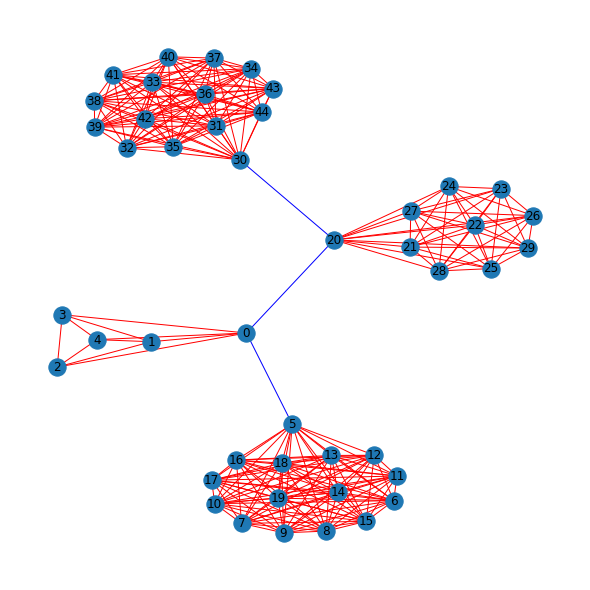

In [15]:
network = NISQNetwork([[0,1], [0,2], [2,3]], {0:[i for i in range(5)], 1:[i for i in range(5, 20)], 2:[i for i in range(20,30)], 3:[i for i in range(30,45)]})
network.draw_nisq_network()

and circuit:

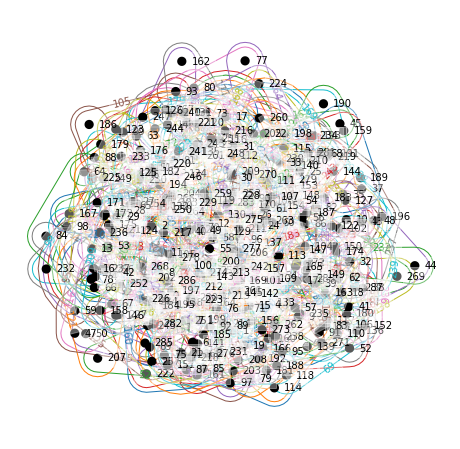

In [16]:
from pytket_dqc.circuits import RegularGraphHypergraphCircuit

dist_circ = RegularGraphHypergraphCircuit(34,3,5)
render_circuit_jupyter(dist_circ.circuit)
dist_circ.draw()

`Annealing` now takes a non-negligible time to find a distribution. However, the solution is valid, and of those that generate a valid solution, it is the best

In [17]:
start = time.time()
distribution = annealing_alloc.allocate(dist_circ, network)
print("time to distribute", time.time() - start)
print("final placement", distribution.placement)
print("final placement cost", distribution.placement.cost(dist_circ, network))

time to distribute 0.16503596305847168
final placement {0: 3, 66: 3, 69: 3, 74: 2, 128: 3, 130: 2, 133: 2, 137: 2, 138: 0, 141: 1, 211: 3, 214: 3, 237: 3, 256: 3, 268: 3, 285: 3, 1: 1, 36: 1, 58: 2, 60: 2, 104: 2, 114: 0, 117: 0, 160: 1, 164: 1, 168: 1, 218: 1, 222: 1, 227: 1, 257: 1, 276: 1, 280: 0, 2: 2, 40: 2, 81: 2, 96: 2, 101: 2, 105: 0, 173: 2, 177: 2, 179: 2, 195: 2, 199: 2, 230: 2, 249: 2, 283: 2, 3: 0, 37: 0, 55: 0, 82: 1, 86: 2, 90: 2, 155: 0, 169: 1, 180: 0, 206: 0, 215: 1, 238: 0, 261: 0, 269: 0, 4: 2, 34: 2, 38: 2, 41: 2, 97: 2, 108: 2, 111: 2, 139: 2, 142: 2, 145: 2, 181: 2, 202: 2, 262: 0, 271: 1, 272: 2, 5: 2, 62: 2, 71: 0, 91: 2, 106: 0, 150: 0, 165: 2, 170: 2, 189: 2, 191: 2, 196: 2, 251: 0, 258: 2, 6: 0, 67: 0, 70: 0, 109: 0, 118: 0, 151: 2, 156: 0, 161: 2, 166: 0, 197: 0, 207: 0, 231: 0, 242: 0, 245: 0, 7: 3, 50: 0, 75: 2, 78: 0, 87: 2, 92: 2, 157: 2, 178: 2, 192: 3, 200: 2, 203: 3, 208: 2, 252: 3, 264: 2, 8: 1, 42: 1, 46: 1, 51: 1, 119: 2, 121: 1, 124: 0, 146: 1, 1

In the case of `GraphPartitioning` we can choose how many refinement rounds are done after the initial partitioning by KaHyPar. These refinement rounds are meant to reduce the cost taking into account the restricted network connectivity, which KaHyPar cannot manage on its own. If `num_rounds` is set to zero, the outcome corresponds to that of KaHyPar with no refinement. A validity pass is always applied (even if `num_rounds = 0`) to ensure that the placement returned is valid.

In [18]:
start = time.time()
distribution = hypergraph_alloc.allocate(dist_circ, network, num_rounds=0)
print("time to distribute", time.time() - start)
print("final placement", distribution.placement)
print("final placement cost", distribution.placement.cost(dist_circ, network))

time to distribute 0.08422207832336426
final placement {0: 1, 1: 2, 2: 3, 3: 3, 4: 3, 5: 3, 6: 2, 7: 1, 8: 3, 9: 1, 10: 1, 11: 1, 12: 3, 13: 2, 14: 1, 15: 1, 16: 2, 17: 3, 18: 3, 19: 1, 20: 3, 21: 3, 22: 2, 23: 1, 24: 3, 25: 1, 26: 3, 27: 3, 28: 2, 29: 2, 30: 1, 31: 0, 32: 1, 33: 2, 34: 3, 35: 3, 36: 3, 37: 3, 38: 3, 39: 1, 40: 3, 41: 3, 42: 3, 43: 1, 44: 1, 45: 2, 46: 3, 47: 2, 48: 1, 49: 3, 50: 2, 51: 3, 52: 1, 53: 2, 54: 1, 55: 3, 56: 1, 57: 1, 58: 3, 59: 2, 60: 2, 61: 1, 62: 3, 63: 1, 64: 3, 65: 1, 66: 1, 67: 2, 68: 1, 69: 1, 70: 2, 71: 3, 72: 1, 73: 2, 74: 2, 75: 1, 76: 1, 77: 2, 78: 2, 79: 1, 80: 3, 81: 3, 82: 3, 83: 1, 84: 2, 85: 1, 86: 2, 87: 1, 88: 2, 89: 3, 90: 3, 91: 3, 92: 3, 93: 2, 94: 1, 95: 1, 96: 3, 97: 3, 98: 2, 99: 3, 100: 3, 101: 3, 102: 2, 103: 2, 104: 2, 105: 3, 106: 3, 107: 2, 108: 3, 109: 2, 110: 3, 111: 3, 112: 3, 113: 1, 114: 2, 115: 3, 116: 3, 117: 2, 118: 2, 119: 2, 120: 3, 121: 2, 122: 2, 123: 3, 124: 2, 125: 2, 126: 3, 127: 1, 128: 1, 129: 2, 130: 1, 131: 0

Alternatively, we can ask for `num_rounds=100` so that there is some refinement being done. This improves the placement cost significantly at the cost of some extra time.

In [19]:
start = time.time()
distribution = hypergraph_alloc.allocate(dist_circ, network, num_rounds=100)
print("time to distribute", time.time() - start)
print("final placement", distribution.placement)
print("final placement cost", distribution.placement.cost(dist_circ, network))

time to distribute 0.8062319755554199
final placement {0: 1, 1: 2, 2: 3, 3: 3, 4: 3, 5: 3, 6: 2, 7: 1, 8: 3, 9: 1, 10: 1, 11: 1, 12: 3, 13: 2, 14: 1, 15: 1, 16: 2, 17: 3, 18: 3, 19: 1, 20: 3, 21: 2, 22: 2, 23: 1, 24: 3, 25: 1, 26: 3, 27: 3, 28: 2, 29: 2, 30: 1, 31: 2, 32: 1, 33: 2, 34: 3, 35: 3, 36: 2, 37: 3, 38: 3, 39: 1, 40: 3, 41: 3, 42: 2, 43: 1, 44: 1, 45: 2, 46: 1, 47: 2, 48: 1, 49: 2, 50: 2, 51: 3, 52: 1, 53: 2, 54: 1, 55: 3, 56: 1, 57: 1, 58: 2, 59: 2, 60: 2, 61: 1, 62: 1, 63: 1, 64: 1, 65: 1, 66: 1, 67: 2, 68: 1, 69: 1, 70: 2, 71: 2, 72: 1, 73: 2, 74: 1, 75: 1, 76: 1, 77: 2, 78: 1, 79: 1, 80: 3, 81: 3, 82: 3, 83: 1, 84: 2, 85: 1, 86: 3, 87: 1, 88: 2, 89: 2, 90: 3, 91: 3, 92: 3, 93: 2, 94: 1, 95: 1, 96: 3, 97: 3, 98: 2, 99: 2, 100: 2, 101: 3, 102: 2, 103: 2, 104: 2, 105: 3, 106: 3, 107: 2, 108: 3, 109: 2, 110: 3, 111: 3, 112: 3, 113: 1, 114: 2, 115: 2, 116: 3, 117: 2, 118: 1, 119: 2, 120: 3, 121: 2, 122: 1, 123: 2, 124: 2, 125: 1, 126: 2, 127: 1, 128: 1, 129: 2, 130: 1, 131: 2,

If we do not specify a value for `num_rounds` it defaults to 1000 rounds. The algorithm has a halting criterion that stops it before running all of those rounds if it realises that the improvement being made on each iteration is no longer noticeable.

`Routing` is now noticeably slow, and the solution quite poor.

In [20]:
start = time.time()
distribution = routing_alloc.allocate(dist_circ, network)
print("time to distribute", time.time() - start)
print("final placement", distribution.placement)
print("final placement cost", distribution.placement.cost(dist_circ, network))

time to distribute 57.5873658657074
final placement {0: 0, 62: 0, 69: 1, 72: 0, 73: 0, 75: 2, 76: 0, 77: 0, 79: 1, 81: 0, 85: 0, 87: 2, 89: 0, 90: 1, 95: 0, 97: 0, 99: 0, 100: 0, 101: 2, 102: 0, 103: 0, 105: 1, 109: 0, 110: 0, 120: 0, 122: 2, 123: 0, 124: 0, 126: 1, 127: 0, 128: 0, 135: 0, 137: 2, 138: 0, 139: 0, 140: 0, 142: 1, 144: 0, 148: 2, 150: 0, 152: 0, 154: 0, 155: 0, 156: 2, 157: 0, 158: 0, 160: 1, 162: 0, 163: 0, 165: 2, 168: 0, 174: 0, 176: 1, 178: 0, 179: 0, 182: 2, 185: 0, 187: 0, 190: 0, 194: 0, 196: 0, 200: 0, 201: 2, 202: 0, 203: 0, 205: 1, 207: 0, 211: 0, 215: 2, 217: 0, 218: 0, 222: 1, 225: 0, 231: 0, 233: 2, 235: 0, 236: 0, 238: 1, 240: 0, 242: 0, 250: 0, 251: 1, 252: 0, 253: 0, 254: 0, 257: 0, 259: 0, 262: 0, 263: 1, 264: 0, 265: 0, 267: 2, 268: 0, 269: 0, 271: 1, 273: 0, 277: 0, 279: 2, 281: 0, 283: 1, 290: 0, 293: 0, 295: 1, 297: 0, 298: 0, 301: 0, 305: 0, 307: 0, 308: 0, 310: 2, 311: 0, 312: 0, 319: 2, 325: 0, 326: 2, 327: 0, 328: 0, 329: 1, 330: 0, 331: 0, 332: 

final placement cost 449


## Circuit Generation

Once a placement has been obtained, it it possible to use pytket-dqc to generate a distributed circuit which implements the original circuit between several servers. There are two circuit generation methods which may be used according to the detail required. 

Let's consider the following simple circuit as an example.

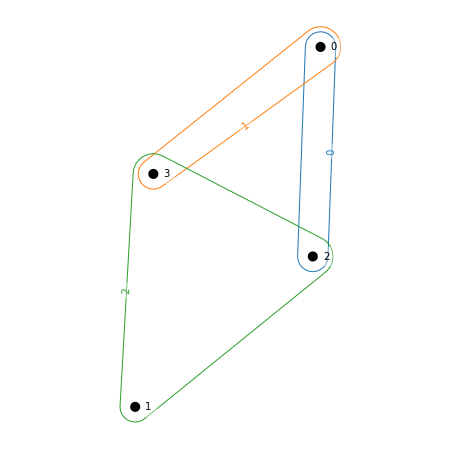

In [21]:
circ = Circuit(2)
circ.CZ(0,1).Rx(0.3,0).CZ(0,1)
render_circuit_jupyter(circ)

dist_circ = HypergraphCircuit(circ)
dist_circ.draw()

Which we will place on the following simple network

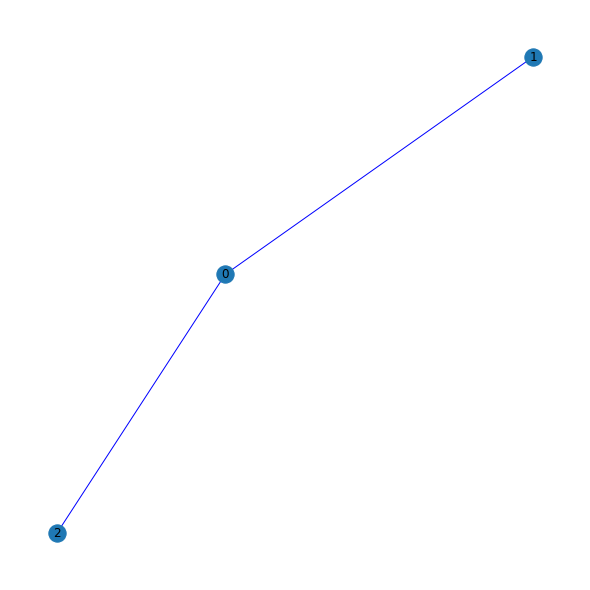

In [22]:
network = NISQNetwork([[0,1], [0,2]], {0:[0], 1:[1], 2:[2]})
network.draw_nisq_network()

The first circuit generation method will simply relabel the qubit registers.

In [23]:
from pytket_dqc.placement import Placement

placement = Placement({0:1, 1:2, 2:0, 3:0})
assert dist_circ.is_placement(placement)

circ_with_dist = dist_circ.to_relabeled_registers(placement)
render_circuit_jupyter(circ_with_dist)

The second will additionally generate all of the necessary distributed gates.

In [24]:
circ_with_dist = dist_circ.to_pytket_circuit(placement, network)
render_circuit_jupyter(circ_with_dist)

Notice firstly that there is one link qubit added for each e-bit. Secondly we see that the gates are acted on a different server from the servers where the qubits are placed. As such in this case we have one server which consists of only link qubits.

`pytket-dqc` will make some effort to use the minimum number of distribution operations required to implement a sequence of gates remotely, given a `Placement`. Consider for example the following three pronged star network.

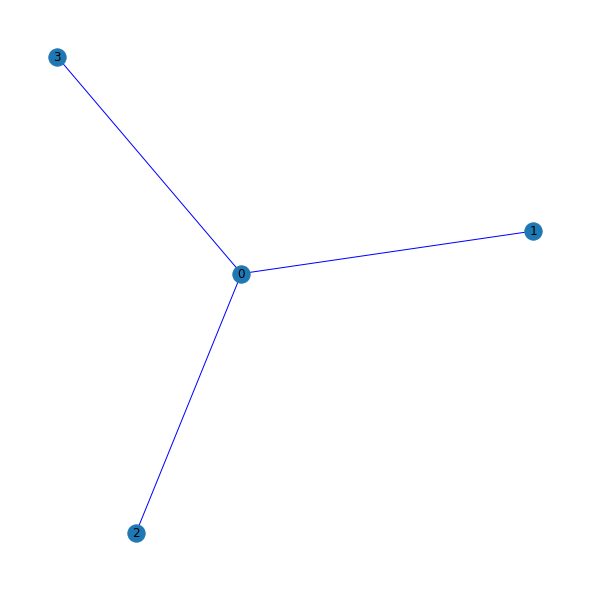

In [25]:
network = NISQNetwork([[0,1], [0,2], [0,3]], {0:[0], 1:[1], 2:[2], 3:[3]})
network.draw_nisq_network()

and the following simple three qubit circuit.

In [26]:
circ = Circuit(3)
circ.CZ(0,1).CZ(0,2)
render_circuit_jupyter(circ)

Imagine the qubits of this circuit are placed on the prongs of this network, and the gates on the servers that hold their target. Then the minimal way to distribute these gates is to copy the information contained in the control qubit to the central server, and then copy the information again from there to the two other edge servers. `pytket-dqc` will take this approach, as seen here.

In [27]:
dist_circ = HypergraphCircuit(circ)

placement = Placement({0:1, 1:2, 2:3, 3:2, 4:3})
assert dist_circ.is_placement(placement)

circ_with_dist = dist_circ.to_pytket_circuit(placement, network)
render_circuit_jupyter(circ_with_dist)

More formally, `pytket-dqc` will consume e-bits along the edges of the [Steiner tree](https://en.wikipedia.org/wiki/Steiner_tree_problem) which connects the servers in which the qubits acted on by the sequence of gates reside.

# Small example to check trivial partition

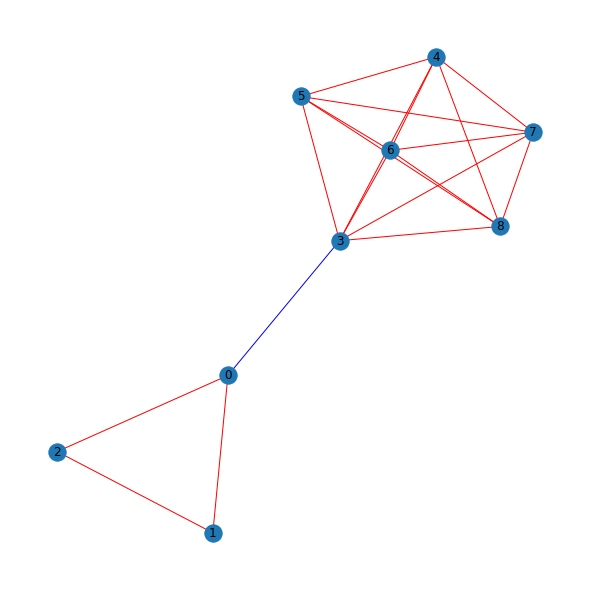

In [28]:
network = NISQNetwork([[0,1]], {0:[i for i in range(3)], 1:[i for i in range(3, 9)]})
network.draw_nisq_network()

In [29]:
from pytket.circuit import CircBox, QControlBox, Op, OpType

op = Op.create(OpType.V)
cv = QControlBox(op, 1)

circ = Circuit(4)
circ.CZ(0,1) 
circ.CZ(0,2) 
circ.Rx(0.3,2)
circ.CZ(1,3) 
circ.Rx(0.3,0)
circ.CZ(1,2) 
circ.CZ(0,3) 
dist_circ = HypergraphCircuit(circ)

render_circuit_jupyter(circ)

In [30]:
distribution = hypergraph_alloc.allocate(dist_circ, network)
print("final placement", distribution.placement)
print("final placement cost", distribution.placement.cost(dist_circ, network))

final placement {0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1}
final placement cost 0


The final placement cost is zero since all of the vertices are placed in the same server. Such behaviour is guaranteed if `num_rounds` is left to its default value or is greater than 0.

# Working with cache

The current implementation of `GraphPartitioning` (and, in particular, the refinement algorithm) makes use of a cache to store precomputed costs. For each subset of servers, the cache stores the cost of communicating these servers in an efficient way (finding their Steiner tree in the network). The size of this cache can be toggled using parameter `cache_limit` which establishes a limit on the cardinality of the subsets of servers whose cost will be stored in cache: if the subset has more servers than `cache_limit` then its cost will be computed but not stored in the cache. If there are N servers and m = `max_key_size` then the cache will store up to N^m values. Default value is 5.

Let's test the effect of the cache on performance for a large example.

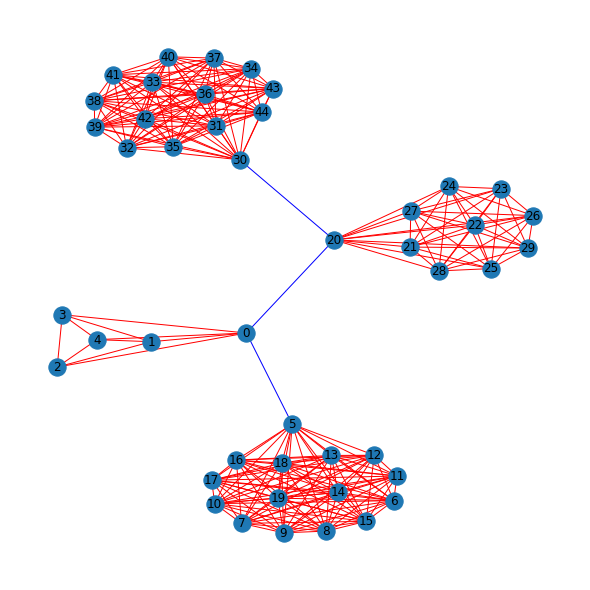

In [31]:
network = NISQNetwork([[0,1], [0,2], [2,3]], {0:[i for i in range(5)], 1:[i for i in range(5, 20)], 2:[i for i in range(20,30)], 3:[i for i in range(30,45)]})
network.draw_nisq_network()

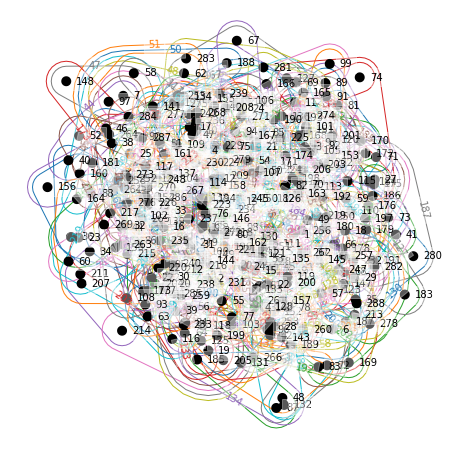

In [32]:
dist_circ = RegularGraphHypergraphCircuit(34,3,5)
render_circuit_jupyter(dist_circ.circuit)
dist_circ.draw()

Using `cache_limit=5` (which is the default value) we get:

In [33]:
start = time.time()
distribution = hypergraph_alloc.allocate(dist_circ, network, cache_limit=5)
print("time to distribute", time.time() - start)
print("final placement cost", distribution.placement.cost(dist_circ, network))

time to distribute 7.817710876464844
final placement cost 141


And if set `cache_limit=0` the cache is never used:

In [ ]:
start = time.time()
distribution = hypergraph_alloc.allocate(dist_circ, network, cache_limit=0)
print("time to distribute", time.time() - start)
print("final placement cost", distribution.placement.cost(dist_circ, network))

The final placement cost should not be affected (if the cost happens to be different, it would be due to the undeterministic nature of the algorithm). The point of using a cache is to make a difference in time and, indeed, when using a `cache_limit=5` the algorithm runs on my computer in less than 2 seconds, but using `cache_limit=0` takes around 100 seconds.